In [91]:
random_seed=42
torch.manual_seed(random_seed)
import torch
from sklearn.preprocessing import MinMaxScaler 
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import  train_test_split
import warnings
warnings.filterwarnings("ignore")
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

## Training and Validation Datasets

While building real-world machine learning models, it is quite common to split the dataset into three parts:

1. **Training set** - used to train the model, i.e., compute the loss and adjust the model's weights using gradient descent.
2. **Validation set** - used to evaluate the model during training, adjust hyperparameters (learning rate, etc.), and pick the best version of the model.
3. **Test set** - used to compare different models or approaches and report the model's final accuracy.

In the MNIST dataset, there are 60,000 training images and 10,000 test images. The test set is standardized so that different researchers can report their models' results against the same collection of images. 

Since there's no predefined validation set, we must manually split the 60,000 images into training and validation datasets. Let's set aside 10,000 randomly chosen images for testing. We can do this using the `random_spilt` method from PyTorch.

In [92]:
# device config
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")

# hyperparams
input_size=784
batch_size=64
learning_rate=0.001
num_classes=10
epochs=25

In [93]:
# Get the data
train_set= torchvision.datasets.MNIST(root="data",
                                      train=True,
                                      transform=transforms.ToTensor(),
                                      download=True
                                     )

test_set= torchvision.datasets.MNIST(root="data",
                                    train=False,
                                    transform=transforms.ToTensor())                                             

In [94]:
## create DataLoader
train_loader=torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)

test_loader= torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=False)

We set `shuffle=True` for the training data loader to ensure that the batches generated in each epoch are different. This randomization helps generalize & speed up the training process. On the other hand, since the validation data loader is used only for evaluating the model, there is no need to shuffle the images.

labels tensor([1, 2, 8, 5, 2, 6, 9, 9, 9, 4, 0, 3, 9, 9, 5, 6, 7, 8, 8, 9, 2, 6, 9, 3,
        0, 5, 0, 7, 6, 1, 2, 0, 7, 4, 6, 0, 6, 9, 7, 0, 7, 3, 2, 5, 9, 0, 4, 8,
        3, 6, 4, 0, 3, 2, 6, 6, 3, 2, 2, 3, 6, 7, 8, 4])


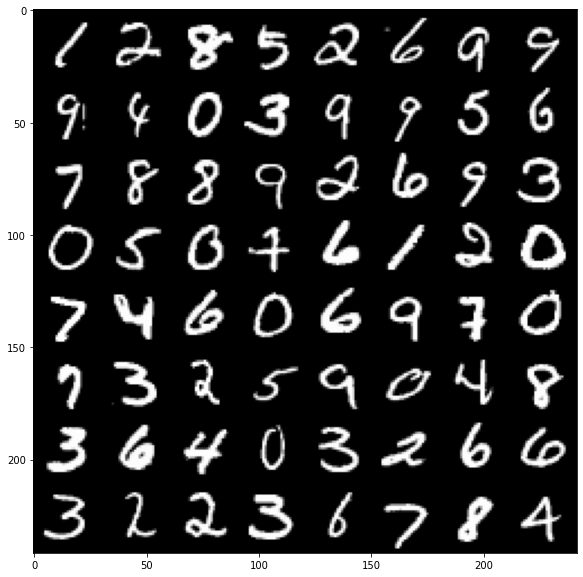

In [95]:
## look at one batch of data
images,labels=next(iter(train_loader))
grid=torchvision.utils.make_grid(images,nrows=10)
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(grid,(1,2,0)))
print("labels",labels)

In [96]:
class Data(Dataset):
    def __init__(self,data):
        self.data=data
        self.rand_num=random.randint(0,9) # generating random integer between 0 to 9
    def __getitem__(self,index):
        image=self.data[index][0]
        label=self.data[index][1]               
        rand_num=self.rand_num        
        sum_=label+rand_num # creating sum to be used as a target column

        # return the image and all the associated labels 
        # this dictionary has image, numeric data which is a list of image label and random integer and 
        # target as label which is also a dictionary with image label and sum of the image label and random integer
        sample={"image":image,"numeric_data":torch.FloatTensor([label,rand_num]),"label":{"image_label":label,"sum":sum_}}
        return sample

    def __len__(self):
        return len(self.data)    

In [97]:
#Create the dataloader for each dataset
train_data=Data(train_set)
test_data=Data(test_set)

train_loader= torch.utils.data.DataLoader(train_data,batch_size=64,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_data,batch_size=64,shuffle=False)

In [98]:
sample=next(iter(train_loader))
print("Keys in our sample batch:",sample.keys())
print("Size of images",sample["image"].shape)
print("Size of numeric data",sample["numeric_data"].shape)
print("Size of target in our sample batch",sample["label"]["image_label"].shape)

Keys in our sample batch: dict_keys(['image', 'numeric_data', 'label'])
Size of images torch.Size([64, 1, 28, 28])
Size of numeric data torch.Size([64, 2])
Size of target in our sample batch torch.Size([64])


Architecture

Now to get into the actual model. We need one convolutional neural network for our image data and a multi-layer perceptron for our tabular data. Both need to be combined and need to return a single prediction value. First, we define a single conv_block, a small custom CNN-layer that expects an input and output dimension. This will save us a bit of repetitive code writing later on.

In [99]:
import torch.nn.functional as F
def conv_block(in_ch,out_ch):
    block= nn.Sequential(nn.Conv2d(in_ch,out_ch,(3,3)),nn.ReLU(),nn.MaxPool2d(2,2))
    return block


In [108]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1= conv_block(1,32)
        self.conv2= conv_block(32,64)
        self.conv3= conv_block(64,128)

        self.ln1= nn.Linear(128*1*1,64)
        self.relu=nn.ReLU()
        self.batchnorm = nn.BatchNorm1d(64)
        self.ln2= nn.Linear(64,10)
        self.ln3= nn.Linear(2,40)
        self.ln4= nn.Linear(40,20)
        self.ln5= nn.Linear(20,10)
        self.ln6= nn.Linear(20,1)
            

        self.image_label= nn.Sequential(self.ln1,self.relu,self.ln2)
        
    def forward(self,img,tab):
        img= self.conv1(img)
        img= self.conv2(img)
        img= self.conv3(img)
        # the input for the classifier should be two-dimensional, but we will have
        # [<batch_size>, <channels>, <width>, <height>]
        # flatten the output of conv2 to (batch_size, 128 * 1 * 1)
        features= img.reshape(img.shape[0],-1)
        
        # create separate classifiers for our outputs
        output_label= self.image_label(features) # this will classify the image of the digit
        
        # output of regressor
        img=self.ln1(features)
        img= self.relu(img)
        img = self.batchnorm(img)
        img= self.ln2(img)# output of CNN
        img= self.relu(img)

        tab= self.ln3(tab)
        tab= self.relu(tab)
        tab= self.ln4(tab) # output of MLP
        tab= self.relu(tab)
        tab= self.ln5(tab)
        tab= self.relu(tab)
        
        x= torch.cat((img,tab),dim=1) # concatenating the features extracted from CNN and MLP
        x= self.relu(x)
        x= self.ln6(x) # this will give the output of the addition operation
        return {"Sum":x, "img_label":output_label }    


The forward() function represents our architecture. The function accepts image and tabular(integer data) data. The image data is used as input data in the CNN layers. Then, we run the tabular data through the multi-layer perceptron. The secret of multi-input neural networks in PyTorch comes after the last tabular line: torch.cat() combines the output data of the CNN with the output data of the MLP. The output of our CNN has a size of 10; the output of the MLP is also 10. Combining the two gives us a new input size of 20 for the last linear layer. Since we are doing regression ,we do not need a softmax function in the end.

We create a flexible training routine that takes into account all outputs of our model. Therefore, it does not matter whether we have 2, 3 or, for example, 5 classifier heads. We simply use the conventional loss function for multiclassification tasks. We calculate the CrossEntropyLoss for digit classifier and for regression we need MSE and then we sum the Losses. This way we can optimize the weights with a single optimizer step for both the heads:

In [101]:
def criterion(net_output,ground_truth):
    classifier_loss= F.cross_entropy(net_output["img_label"],ground_truth["image_label"].to(device))
    regressor_loss= F.mse_loss(net_output["Sum"],ground_truth["sum"].to(torch.float32).to(device))
    loss= classifier_loss+regressor_loss

    return loss,{"img_labe":classifier_loss,"sum":regressor_loss}


Now we have both model and data ready. Let’s start the training.

In [109]:
epochs=25
batch_size=64
model=ConvNet().to(device)


In [110]:
for i, data in enumerate(train_loader):
    print(data["label"]["image_label"].device)
    # img= data["image"].to(device)
    # tab= data["numeric_data"].to(device)
    # print(data["label"]["sum"].dtype)
    # outputs= model(img,tab)
    # print(data["label"]["sum"].device)
    # print(outputs["Sum"].shape)
    # loss= criterion(outputs,data["label"].cuda())
    # print(loss[0].item())
    break

cpu


In [111]:
def training(model,epochs,training_data):
    num_epochs=epochs
    losses=[]
    checkpoint_losses = []

    optimizer= torch.optim.Adam(model.parameters(),lr=0.001)
    n_total_steps= len(train_loader)

    for epochs in range(num_epochs):
        for i, data in enumerate(train_loader):
            img= data["image"].to(device)
            tab= data["numeric_data"].to(device)
            outputs= model(img,tab)

            loss_train,_= criterion(outputs,data["label"])
            losses.append(loss_train.item())

            optimizer.zero_grad()
            loss_train.backward()

            optimizer.step()

            if(i+1)% int(n_total_steps/1)==0:
                checkpoint_loss = torch.tensor(losses).mean().item()
                checkpoint_losses.append(checkpoint_loss)
                print(f"epoch [{epochs+1}/{num_epochs}] Step [{i+1}/{n_total_steps}] Loss:{checkpoint_loss:.4f}] ")
    return checkpoint_losses

checkpoint_losses=training(model,epochs=25,training_data=train_loader)
            

epoch [1/25] Step [938/938] Loss:14.3463] 
epoch [2/25] Step [938/938] Loss:11.4465] 
epoch [3/25] Step [938/938] Loss:10.4510] 
epoch [4/25] Step [938/938] Loss:9.9464] 
epoch [5/25] Step [938/938] Loss:9.6395] 
epoch [6/25] Step [938/938] Loss:9.4299] 
epoch [7/25] Step [938/938] Loss:9.2780] 
epoch [8/25] Step [938/938] Loss:9.1631] 
epoch [9/25] Step [938/938] Loss:9.0723] 
epoch [10/25] Step [938/938] Loss:8.9976] 
epoch [11/25] Step [938/938] Loss:8.9351] 
epoch [12/25] Step [938/938] Loss:8.8819] 
epoch [13/25] Step [938/938] Loss:8.8373] 
epoch [14/25] Step [938/938] Loss:8.7980] 
epoch [15/25] Step [938/938] Loss:8.7631] 
epoch [16/25] Step [938/938] Loss:8.7329] 
epoch [17/25] Step [938/938] Loss:8.7058] 
epoch [18/25] Step [938/938] Loss:8.6812] 
epoch [19/25] Step [938/938] Loss:8.6595] 
epoch [20/25] Step [938/938] Loss:8.6396] 
epoch [21/25] Step [938/938] Loss:8.6221] 
epoch [22/25] Step [938/938] Loss:8.6055] 
epoch [23/25] Step [938/938] Loss:8.5905] 
epoch [24/25] Ste

In [112]:
# put the model into evaluation mode
model.eval()
# initialize storage for ground truth and predicted labels
predicted_label_all = []
gt_label_all = []

predicted_sum_all=[]
gt_sum_all=[]

with torch.no_grad():
   
  # go over all the images
  for batch in test_loader:
    
    images = batch["image"]
    tab= batch["numeric_data"].to(device)
    # labels = [batch['label'][labels].to(device) for labels in batch['label']]
    
    # #  we're going to build the confusion matrix for "label" predictions
    gt_labels = batch["label"]["image_label"]
    target_labels = {"img_labels": gt_labels.to(device)}

    gt_sums= batch["label"]["sum"]
    # # get the model outputs
    output = model(images.to(device),tab)
    
    # get the most confident prediction for each image
    _, predicted_label = output["img_label"].cpu().max(1)
    predicted_sum= output["Sum"].cpu()
    
    predicted_label_all.extend(prediction.item() for prediction in predicted_label)
    gt_label_all.extend(gt_label.item() for gt_label in gt_labels)

    # predicted_sum_all.extend(prediction.item() for prediction in predicted_label)
    # gt_label_all.extend(gt_sum for gt_sum in gt_sums)
    

In [114]:
from sklearn.metrics import accuracy_score,r2_score,confusion_matrix
import itertools
accuracy = accuracy_score(gt_label_all, predicted_label_all)
r_squared=r2_score(gt_sums,predicted_sum)

print("Accuracy of the model:",accuracy)
print("R Squared valued of the model:",r_squared)

Accuracy of the model: 0.9895
R Squared valued of the model: 0.22423644215888938


In [119]:
# Look at confusion matrix 
confusion_mtx = confusion_matrix(gt_label_all, predicted_label_all)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

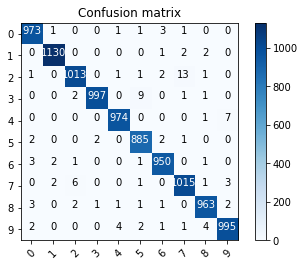

In [120]:
plot_confusion_matrix(confusion_mtx,classes = range(10))